In this notebook, we test the loading speed for raster satellite data <br> stored in different data formats and
for different preprocessing steps for the purpose of using
it in a deep-learning dataset.

Any questions? Contact jonathanprexl@gmail.com


For running the code in this notebook please download the Sentinel-2 image:<br> 
**S2B_MSIL2A_20230928T101719_N0509_R065_T32UPU_20230928T145710.SAFE**<br> 
from https://dataspace.copernicus.eu/ and store it in the same directory as the notebook.

# Imports

In [1]:
import rasterio as rio
from rasterio.windows import Window
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.enums import Compression

import time
import os, glob
import numpy as np
import h5py

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
if not os.path.isdir("./S2B_MSIL2A_20230928T101719_N0509_R065_T32UPU_20230928T145710.SAFE"):
    raise FileNotFoundError("you need to download and extract the S2 file first")

# Hyperparams

In [3]:
numSamples = 1024 # statistics over N samples
patchsize = 256 # patchsize to load

tempdir = "./tmp" # location for temporary files
os.makedirs(tempdir,exist_ok=True)

In [4]:
globaltimes = dict()

# Loading from the default .jp2 files

Often Sentinel-2 data gets shipped in the .SAFE format where all bands are stored in separate files in the .jp2 format.
The file covers approximately an area of 100km² x 100km². We can load random patches via the windowed loading function of rasterio. 
If we use this format as is then upsampling of the non 10m GSD bands takes place during loading (ofc a bit slower).
This is the default method (our baseline) without any preprocessing or change of data format.

Get the location of all the seperate files

In [5]:
def get_S2_locations(s2_dir):
    
    s2_b01 = glob.glob(os.path.join(s2_dir,"**","*B01_60m.jp2"),recursive=True)
    s2_b02 = glob.glob(os.path.join(s2_dir,"**","*B02_10m.jp2"),recursive=True)
    s2_b03 = glob.glob(os.path.join(s2_dir,"**","*B03_10m.jp2"),recursive=True)
    s2_b04 = glob.glob(os.path.join(s2_dir,"**","*B04_10m.jp2"),recursive=True)
    s2_b05 = glob.glob(os.path.join(s2_dir,"**","*B05_20m.jp2"),recursive=True)
    s2_b06 = glob.glob(os.path.join(s2_dir,"**","*B06_20m.jp2"),recursive=True)
    s2_b07 = glob.glob(os.path.join(s2_dir,"**","*B07_20m.jp2"),recursive=True)
    s2_b08 = glob.glob(os.path.join(s2_dir,"**","*B08_10m.jp2"),recursive=True)
    s2_b8a = glob.glob(os.path.join(s2_dir,"**","*B8A_20m.jp2"),recursive=True)
    s2_b09 = glob.glob(os.path.join(s2_dir,"**","*B09_60m.jp2"),recursive=True)
    s2_b11 = glob.glob(os.path.join(s2_dir,"**","*B11_20m.jp2"),recursive=True)
    s2_b12 = glob.glob(os.path.join(s2_dir,"**","*B12_20m.jp2"),recursive=True)

    s2_b01 = s2_b01[0]
    s2_b02 = s2_b02[0]
    s2_b03 = s2_b03[0]
    s2_b04 = s2_b04[0]
    s2_b05 = s2_b05[0]
    s2_b06 = s2_b06[0]
    s2_b07 = s2_b07[0]
    s2_b08 = s2_b08[0]
    s2_b8a = s2_b8a[0]
    s2_b09 = s2_b09[0]
    s2_b11 = s2_b11[0]
    s2_b12 = s2_b12[0]
    
    return {"b01":s2_b01,"b02":s2_b02,"b03":s2_b03,"b04":s2_b04,"b05":s2_b05,
            "b06":s2_b06,"b07":s2_b07,"b08":s2_b08,"b8a":s2_b8a,"b09":s2_b09,
            "b11":s2_b11,"b12":s2_b12}

In [6]:
locs_raw = get_S2_locations("./S2B_MSIL2A_20230928T101719_N0509_R065_T32UPU_20230928T145710.SAFE/")

### Load random patches

loading of N random patches from the 100km² x 100km² file.

In [7]:
times = [] # store loading times

# get the bounds of the raster
with rio.open(locs_raw["b02"],"r") as src:
    bounds = src.bounds
    transform = src.transform

# load N random windows
for i in range(numSamples):
    
    x0,y0 = np.random.randint(0,10980-patchsize,2)
    new_left = bounds.left + x0*10
    new_bottom = bounds.bottom + y0*10  
    
    t0 = time.time()

    tensor = []
    for band in locs_raw.keys():
        with rio.open(locs_raw[band],"r") as src:
            
            win = from_bounds(new_left,new_bottom,new_left+patchsize*10,new_bottom+patchsize*10,src.transform)

            # no upsampling
            if band in ["b02","b03","b04","b08"]:
                tensor.append( src.read(1, window=win) )

            # upsampling
            else:
                tensor.append( src.read(1, window=win, out_shape=(1,patchsize,patchsize), resampling=Resampling.cubic) )
    
    tensor = np.stack(tensor,axis=0)
    
    t1 = time.time()
    
    times.append(t1-t0)

globaltimes["jp2"] = times

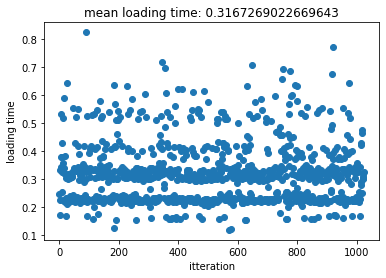

In [8]:
plt.scatter(range(len(times)),times)
plt.title("mean loading time: "+str(np.mean(times)))
plt.ylabel("loading time")
plt.xlabel("itteration")
plt.show()

# Make a geotiff with all data combined and load windows from there

Faster then loading from separate files is if we place all bands into one geotiff beforehand (only have to be done once). Here we can set the tiling variable in the file metadata which influences the i/o speed.

### Save all bands into one geotiff

In [9]:
def toGeotiff(tilling, blocksize=256, overwriteName="", compress=False):

    tensor = []
    for band in locs_raw.keys():
        with rio.open(locs_raw[band],"r") as src:
            if band in ["b02","b03","b04","b08"]:
                tensor.append( src.read(1) )
            else:
                tensor.append( src.read(1, out_shape=(1,10980,10980),resampling=Resampling.cubic) )
    tensor = np.stack(tensor,axis=0)

    with rio.open(locs_raw["b02"],"r") as src:
        meta = src.meta
        
    meta["driver"]="GTiff"
    meta["count"]=12
    meta["dtype"]= rio.uint16

    if compress:
        meta["compress"] = Compression.lzw.name
    else:
        meta["compress"] = Compression.none.name
    
    if tilling:
        meta["tiled"] = True
        meta["blocksize"] = blocksize
    else:
        meta["tiled"] = False

    if overwriteName == "":
        with rio.open(os.path.join(tempdir, f"S2cube_tiled_{str(tilling)}.tif"),"w",**meta) as dst:
            dst.write(tensor)
    else:
        with rio.open(overwriteName,"w",**meta) as dst:
            dst.write(tensor)
            
    return None

In [ ]:
toGeotiff(tilling=False)
toGeotiff(tilling=True)

### load from the cube without tilling

In [ ]:
times = []

# get the bounds of the raster
with rio.open(os.path.join(tempdir,"S2cube_tiled_False.tif"),"r") as src:
    bounds = src.bounds
    transform = src.transform

# load N random windows
for i in range(numSamples):
    
    x0,y0 = np.random.randint(0,10980-patchsize,2)
    new_left = bounds.left + x0*10
    new_bottom = bounds.bottom + y0*10  
    
    t0 = time.time()

    with rio.open(os.path.join(tempdir,"S2cube_tiled_False.tif"),"r") as src:

        win = from_bounds(new_left,new_bottom,new_left+patchsize*10,new_bottom+patchsize*10,src.transform)

        tensor = src.read(window=win)

    t1 = time.time()
    
    times.append(t1-t0)

globaltimes["gtif_nT"] = times

In [ ]:
plt.scatter(range(len(times)),times)
plt.title("mean loading time: "+str(np.mean(times)))
plt.ylabel("loading time")
plt.xlabel("itteration")
plt.show()

### load from the cube with tilling

In [ ]:
times = []

# get the bounds of the raster
with rio.open(os.path.join(tempdir,"S2cube_tiled_True.tif"),"r") as src:
    bounds = src.bounds
    transform = src.transform

# load N random windows
for i in range(numSamples):
    
    x0,y0 = np.random.randint(0,10980-patchsize,2)
    new_left = bounds.left + x0*10
    new_bottom = bounds.bottom + y0*10  
    
    t0 = time.time()

    with rio.open(os.path.join(tempdir,"S2cube_tiled_True.tif"),"r") as src:

        win = from_bounds(new_left,new_bottom,new_left+patchsize*10,new_bottom+patchsize*10,src.transform)

        tensor = src.read(window=win)

    t1 = time.time()
    
    times.append(t1-t0)

globaltimes["gtif_T"] = times

In [ ]:
plt.scatter(range(len(times)),times)
plt.title("mean loading time: "+str(np.mean(times)))
plt.ylabel("loading time")
plt.xlabel("itteration")
plt.show()

### Try differnt blocksizes

In [ ]:
#for BS in [128,256,512,1024,2048,4096]:
#    
#    toGeotiff(tilling=True, blocksize=BS, overwriteName=os.path.join(tempdir,"itterateBlocksize.tif"))
#
#    times = []
#    
#    # get the bounds of the raster
#    with rio.open(os.path.join(tempdir,"itterateBlocksize.tif"),"r") as src:
#        bounds = src.bounds
#        transform = src.transform
#    
#    # load N random windows
#    for i in range(numSamples):
#        
#        x0,y0 = np.random.randint(0,10980-patchsize,2)
#        new_left = bounds.left + x0*10
#        new_bottom = bounds.bottom + y0*10  
#        
#        t0 = time.time()
#    
#        with rio.open(os.path.join(tempdir,"itterateBlocksize.tif"),"r") as src:
#    
#            win = from_bounds(new_left,new_bottom,new_left+patchsize*10,new_bottom+patchsize*10,src.transform)
#    
#            tensor = src.read(window=win)
#    
#        t1 = time.time()
#        
#        times.append(t1-t0)
#
#    globaltimes[f"gtif_T_iBS_{BS}"] = times
#
#    plt.scatter(range(len(times)),times)
#    plt.title("mean loading time: "+str(np.mean(times))+f" -- Blocksize {BS}")
#    plt.ylabel("loading time")
#    plt.xlabel("itteration")
#    plt.show()

# Loading patches from hdf5 file

Alternativly to reading with windows from a "big" rasterfile we can also prepocess the data beforhand and store the 
seperate patches in a hdf4 file.

### generate data

In [ ]:
# get the bounds of the raster
with rio.open(os.path.join(tempdir,"S2cube_tiled_True.tif"),"r") as src:
    bounds = src.bounds
    transform = src.transform

# write random patches into a hdf5 file
locs = []
with h5py.File(os.path.join(tempdir,'S2patches.h5'), 'w') as hdf:
    # load N random windows
    for i in range(1764): # 1764 is roughtly 42**2 which is the number of 256**2 patches in the 10980x10980 raster
        x0,y0 = np.random.randint(0,10980-patchsize,2)
        new_left = bounds.left + x0*10
        new_bottom = bounds.bottom + y0*10  
        with rio.open(os.path.join(tempdir,"S2cube_tiled_True.tif"),"r") as src:
            win = from_bounds(new_left,new_bottom,new_left+patchsize*10,new_bottom+patchsize*10,src.transform)
            tensor = src.read(window=win)
            hdf.create_dataset(f'dataset_{i}', data=tensor)

### perform read

In [ ]:
times = []

# load N random windows
for i in range(numSamples):

    j = np.random.randint(0,1764)

    t0 = time.time()
    
    with h5py.File(os.path.join(tempdir,'S2patches.h5'), 'r') as hdf:
        data = hdf[f'dataset_{j}'][:]

    t1 = time.time()

    times.append(t1-t0)

globaltimes[f"hdf5"] = times

In [ ]:
plt.scatter(range(len(times)),times)
plt.title("mean loading time: "+str(np.mean(times)))
plt.ylabel("loading time")
plt.xlabel("itteration")
plt.show()

# Compare the results

In [ ]:
stats=dict()
for key, val in globaltimes.items():
    if not "iBS" in key:
        mean = np.mean(val)
        std = np.std(val)
        stats[key] = {'mean': mean, 'std': std}

In [ ]:
keys = list(stats.keys())
means = [stats[key]['mean'] for key in keys]
stds = [stats[key]['std'] for key in keys]


xlabels={
    "jp2": "jp2",
    "gtif_nT": "GTiff without tilling",
    "jp2": "GTiff with tilling",
    "hdf5": "hdf5",
}


plt.errorbar(keys, means, yerr=stds, fmt='o', capsize=5, label='Mean ± STD')
plt.xlabel('dataformat')
plt.ylabel('loadingtime (s)')
plt.title('mean and sdt of the loading speed for dataformat')
plt.legend()
plt.yscale("log")
plt.xticks(rotation=90)
plt.show()